In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image


In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [3]:
#select the image
img = Image.open('Data/Inpainting/kate.png')
to_tensor = transforms.ToTensor()

#select the mask
img_mask = Image.open('Data/Inpainting/kate_mask.png')

to_tensor = transforms.ToTensor()

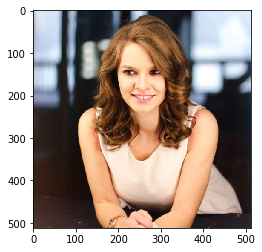

In [4]:
#original image
img = to_tensor(img).permute(1,2,0)
plt.imshow(img)

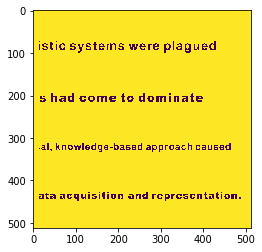

In [5]:
img_mask = to_tensor(img_mask).squeeze(0)
plt.imshow(img_mask)

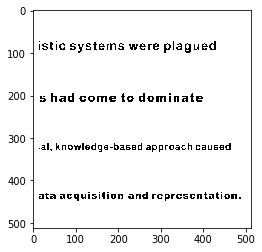

In [6]:
img_mask = img_mask.repeat(1,3,1,1).squeeze(0).permute(1,2,0)
plt.imshow(img_mask)

In [7]:
print(img.shape)
print(img_mask.shape)


torch.Size([512, 512, 3])
torch.Size([512, 512, 3])


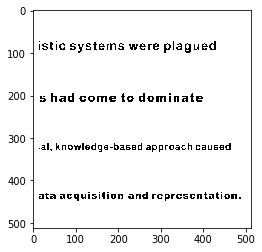

In [8]:
img[img_mask==0] = 0
plt.imshow(img)
img_mask[img_mask!=0] = 1
plt.imshow(img_mask)

#input of our model 
x = img.permute(2,0,1).unsqueeze(0)
mask = img_mask.permute(2,0,1).unsqueeze(0)

In [9]:
# function to plot the corrupted image and mask
def plot_priors(x, mask):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(x)
    f.add_subplot(1,2, 2)
    plt.imshow(mask)
    plt.show(block=True)

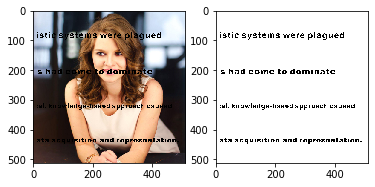

In [10]:
plot_priors(img, img_mask)

In [11]:
#U-Net type architecture with skip connection

class Network(nn.Module):
    def __init__(self, z_size):
        super(Network,self).__init__()

        self.leaky_relu = nn.LeakyReLU()

        self.d_conv_1 = nn.Conv2d(z_size, 8, 5, stride=2, padding=2)
        self.d_bn_1 = nn.BatchNorm2d(8)

        self.d_conv_2 = nn.Conv2d(8, 16, 5, stride=2, padding=2)
        self.d_bn_2 = nn.BatchNorm2d(16)

        self.d_conv_3 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.d_bn_3 = nn.BatchNorm2d(32)
        self.s_conv_3 = nn.Conv2d(32, 4, 5, stride=1, padding=2)

        self.d_conv_4 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.d_bn_4 = nn.BatchNorm2d(64)
        self.s_conv_4 = nn.Conv2d(64, 4, 5, stride=1, padding=2)

        self.d_conv_5 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.d_bn_5 = nn.BatchNorm2d(128)
        self.s_conv_5 = nn.Conv2d(128, 4, 5, stride=1, padding=2)

        self.d_conv_6 = nn.Conv2d(128, 256, 5, stride=2, padding=2)
        self.d_bn_6 = nn.BatchNorm2d(256)

        self.u_deconv_5 = nn.ConvTranspose2d(256, 124, 4, stride=2, padding=1)
        self.u_bn_5 = nn.BatchNorm2d(128)

        self.u_deconv_4 = nn.ConvTranspose2d(128, 60, 4, stride=2, padding=1)
        self.u_bn_4 = nn.BatchNorm2d(64)

        self.u_deconv_3 = nn.ConvTranspose2d(64, 28, 4, stride=2, padding=1)
        self.u_bn_3 = nn.BatchNorm2d(32)

        self.u_deconv_2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.u_bn_2 = nn.BatchNorm2d(16)

        self.u_deconv_1 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1)
        self.u_bn_1 = nn.BatchNorm2d(8)

        self.out_deconv = nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1)
        self.out_bn = nn.BatchNorm2d(3)

    def forward(self, noise):
        down_1 = self.d_conv_1(noise)
        down_1 = self.d_bn_1(down_1)
        down_1 = self.leaky_relu(down_1)

        down_2 = self.d_conv_2(down_1)
        down_2 = self.d_bn_2(down_2)
        down_2 = self.leaky_relu(down_2)

        down_3 = self.d_conv_3(down_2)
        down_3 = self.d_bn_3(down_3)
        down_3 = self.leaky_relu(down_3)
        skip_3 = self.s_conv_3(down_3)

        down_4 = self.d_conv_4(down_3)
        down_4 = self.d_bn_4(down_4)
        down_4 = self.leaky_relu(down_4)
        skip_4 = self.s_conv_4(down_4)

        down_5 = self.d_conv_5(down_4)
        down_5 = self.d_bn_5(down_5)
        down_5 = self.leaky_relu(down_5)
        skip_5 = self.s_conv_5(down_5)

        down_6 = self.d_conv_6(down_5)
        down_6 = self.d_bn_6(down_6)
        down_6 = self.leaky_relu(down_6)

        up_5 = self.u_deconv_5(down_6)
        up_5 = torch.cat([up_5, skip_5], 1)
        up_5 = self.u_bn_5(up_5)
        up_5 = self.leaky_relu(up_5)

        up_4 = self.u_deconv_4(up_5)
        up_4 = torch.cat([up_4, skip_4], 1)
        up_4 = self.u_bn_4(up_4)
        up_4 = self.leaky_relu(up_4)

        up_3 = self.u_deconv_3(up_4)
        up_3 = torch.cat([up_3, skip_3], 1)
        up_3 = self.u_bn_3(up_3)
        up_3 = self.leaky_relu(up_3)

        up_2 = self.u_deconv_2(up_3)
        up_2 = self.u_bn_2(up_2)
        up_2 = self.leaky_relu(up_2)

        up_1 = self.u_deconv_1(up_2)
        up_1 = self.u_bn_1(up_1)
        up_1 = self.leaky_relu(up_1)

        out = self.out_deconv(up_1)
        out = self.out_bn(out)
        out = nn.Sigmoid()(out)

        return out

In [12]:
#latent matrix choosen as per the directions given in supplementry material provided by the author

latent_matrix = np.mgrid[:512, :512]/512
print(type(latent_matrix))
latent_matrix = torch.from_numpy(latent_matrix)


#Hyper parameters
z = latent_matrix.unsqueeze(0)
z = z.double()
device = 'cpu'
num_epochs = 5000
lr = 0.02
z_size = z.shape[1]


model = Network(z_size)
model = model.float()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
print(z_size)

z

<class 'numpy.ndarray'>
2


tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.9941, 0.9941, 0.9941,  ..., 0.9941, 0.9941, 0.9941],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9980, 0.9980, 0.9980,  ..., 0.9980, 0.9980, 0.9980]],

         [[0.0000, 0.0020, 0.0039,  ..., 0.9941, 0.9961, 0.9980],
          [0.0000, 0.0020, 0.0039,  ..., 0.9941, 0.9961, 0.9980],
          [0.0000, 0.0020, 0.0039,  ..., 0.9941, 0.9961, 0.9980],
          ...,
          [0.0000, 0.0020, 0.0039,  ..., 0.9941, 0.9961, 0.9980],
          [0.0000, 0.0020, 0.0039,  ..., 0.9941, 0.9961, 0.9980],
          [0.0000, 0.0020, 0.0039,  ..., 0.9941, 0.9961, 0.9980]]]],
       dtype=torch.float64)

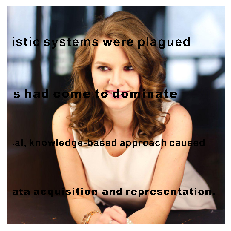

In [13]:

#prior for our model
plt.imshow(img)
plt.axis('off')

plt.savefig("Data/Inpainting/corrupted_img.png", bbox_inches='tight')

In [14]:
model = model.to(device)
z = z.to(device)
x = x.to(device)
mask = mask.to(device)

In [15]:
#Training

losses = []
images = []

for i in range(num_epochs):
    model.zero_grad()
    out = model(z.float())
    loss = criterion(x, out*mask)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    
    if (i+1)%50 ==0:
        out = model(z.float())
        images.append(out.squeeze(0).permute(1,2,0))
        
    if (i+1)%100 == 0:
        print('Epoch : {} , Error : {}'.format(i+1, loss))
    

In [16]:
out = model(z.float())
print(out.shape)

#Model output after training
plt.imshow(out.squeeze(0).permute(1,2,0).detach())

In [17]:
#save the model parameters
torch.save(model.state_dict(), 'params.pth')

In [18]:
#plot losses

plt.plot(losses)